# Ames Housing: End-to-End Regression Project

This notebook walks through a full data science workflow on the Ames Housing dataset:

- Load and inspect the data
- Extensive Exploratory Data Analysis (EDA)
- Preprocessing with different encoders (Ordinal, One-Hot) and scaling
- Model training (Random Forest, Gradient Boosting, XGBoost optional)
- Evaluation with regression metrics
- Explainability: Permutation Importance and SHAP values

You can run each code block in a separate cell in Google Colab.

In [ ]:
# Install extra packages (run once per session)
# !pip install shap xgboost scikit-learn==1.5.0 seaborn matplotlib pandas numpy -q

import warnings
warnings.filterwarnings('ignore')

## 1. Load Data

Upload `AmesHousing.csv` to Colab (left sidebar → Files → Upload) or mount Google Drive and adjust the path.

In [ ]:
import pandas as pd
import numpy as np

# Adjust the path if needed
csv_path = 'AmesHousing.csv'

df = pd.read_csv(csv_path)
print(df.shape)
df.head()

(2930, 82)


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


## 2. Basic Data Overview

- Look at columns, dtypes, missing values.
- Identify the target variable (we'll use `SalePrice`).

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

In [ ]:
df.describe().T.head(20)

,count,mean,std,min,25%,50%,75%,max
Order,2930.0,1.465500e+03,8.459625e+02,1.0,7.332500e+02,1465.5,2.197750e+03,2.930000e+03
PID,2930.0,7.144645e+08,1.887308e+08,526301100.0,5.284770e+08,535453620.0,9.071811e+08,1.007100e+09
MS SubClass,2930.0,5.738737e+01,4.263802e+01,20.0,2.000000e+01,50.0,7.000000e+01,1.900000e+02
Lot Frontage,2440.0,6.922459e+01,2.336533e+01,21.0,5.800000e+01,68.0,8.000000e+01,3.130000e+02
Lot Area,2930.0,1.014792e+04,7.880018e+03,1300.0,7.440250e+03,9436.5,1.155525e+04,2.152450e+05
Overall Qual,2930.0,6.094881e+00,1.411026e+00,1.0,5.000000e+00,6.0,7.000000e+00,1.000000e+01
Overall Cond,2930.0,5.563140e+00,1.111537e+00,1.0,5.000000e+00,5.0,6.000000e+00,9.000000e+00
Year Built,2930.0,1.971356e+03,3.024536e+01,1872.0,1.954000e+03,1973.0,2.001000e+03,2.010000e+03
Year Remod/Add,2930.0,1.984267e+03,2.086029e+01,1950.0,1.965000e+03,1993.0,2.004000e+03,2.010000e+03
Mas Vnr Area,2907.0,1.018968e+02,1.791126e+02,0.0,0.000000e+00,0.0,1.640000e+02,1.600000e+03


In [ ]:
df.describe(include='object').T.head(20)

,count,unique,top,freq
MS Zoning,2930,7,RL,2273
Street,2930,2,Pave,2918
Alley,198,2,Grvl,120
Lot Shape,2930,4,Reg,1859
Land Contour,2930,4,Lvl,2633
Utilities,2930,3,AllPub,2927
Lot Config,2930,5,Inside,2140
Land Slope,2930,3,Gtl,2789
Neighborhood,2930,28,NAmes,443
Condition 1,2930,9,Norm,2522


In [ ]:
# Missing values summary
missing_counts = df.isna().sum().sort_values(ascending=False)
missing_counts[missing_counts > 0].head(30)

,0
Pool QC,2917
Misc Feature,2824
Alley,2732
Fence,2358
Mas Vnr Type,1775
Fireplace Qu,1422
Lot Frontage,490
Garage Qual,159
Garage Yr Blt,159
Garage Cond,159


## 3. Target Variable Exploration (`SalePrice`)

Examine distribution and consider log-transform if skewed.

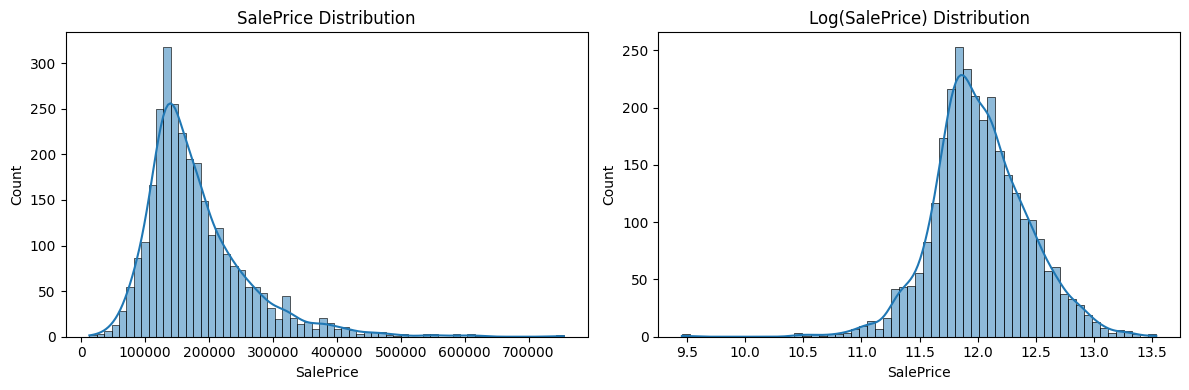

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

target_col = 'SalePrice'

fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df[target_col], kde=True, ax=axes[0])
axes[0].set_title('SalePrice Distribution')
sns.histplot(np.log1p(df[target_col]), kde=True, ax=axes[1])
axes[1].set_title('Log(SalePrice) Distribution')
plt.tight_layout()
plt.show()

We'll predict the log-transformed target to stabilize variance:
$y = \log(1 + \text{SalePrice})$.

In [ ]:
df['SalePrice_log'] = np.log1p(df['SalePrice'])
df[['SalePrice', 'SalePrice_log']].head()

,SalePrice,SalePrice_log
0,215000,12.278398
1,105000,11.561725
2,172000,12.055256
3,244000,12.404928
4,189900,12.154258


## 4. Feature Typing and Basic EDA

Split features into numeric and categorical, and look at some relationships.

In [ ]:
# Identify numeric and categorical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in ['SalePrice', 'SalePrice_log']]
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
print(
len(numeric_cols), len(categorical_cols), numeric_cols[:10], categorical_cols[:10])

38 43 ['Order', 'PID', 'MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area'] ['MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1']


### 4.1 Correlation with Target (Top Numerical Features)

Compute Pearson correlations with `SalePrice_log` for numerical features.

In [ ]:
corrs = df[numeric_cols + ['SalePrice_log']].corr()['SalePrice_log'].sort_values(ascending=False)
corrs.head(15)

,SalePrice_log
SalePrice_log,1.000000
Overall Qual,0.825645
Gr Liv Area,0.695863
Garage Cars,0.675318
Garage Area,0.651132
Total Bsmt SF,0.625099
Year Built,0.615485
1st Flr SF,0.602629
Year Remod/Add,0.586153
Garage Yr Blt,0.580502


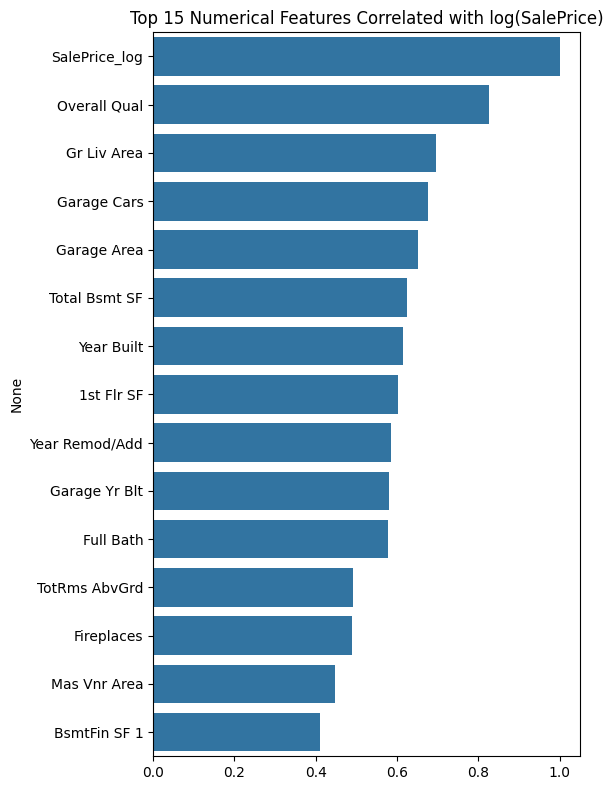

In [ ]:
plt.figure(figsize=(6, 8))
sns.barplot(x=corrs.head(15).values, y=corrs.head(15).index)
plt.title('Top 15 Numerical Features Correlated with log(SalePrice)')
plt.tight_layout()
plt.show()

### 4.2 Pairwise Plots for Key Numeric Features

Look at scatterplots of a few important features vs. `SalePrice_log`.

In [ ]:
sorted(df.columns)

['1st Flr SF',
 '2nd Flr SF',
 '3Ssn Porch',
 'Alley',
 'Bedroom AbvGr',
 'Bldg Type',
 'Bsmt Cond',
 'Bsmt Exposure',
 'Bsmt Full Bath',
 'Bsmt Half Bath',
 'Bsmt Qual',
 'Bsmt Unf SF',
 'BsmtFin SF 1',
 'BsmtFin SF 2',
 'BsmtFin Type 1',
 'BsmtFin Type 2',
 'Central Air',
 'Condition 1',
 'Condition 2',
 'Electrical',
 'Enclosed Porch',
 'Exter Cond',
 'Exter Qual',
 'Exterior 1st',
 'Exterior 2nd',
 'Fence',
 'Fireplace Qu',
 'Fireplaces',
 'Foundation',
 'Full Bath',
 'Functional',
 'Garage Area',
 'Garage Cars',
 'Garage Cond',
 'Garage Finish',
 'Garage Qual',
 'Garage Type',
 'Garage Yr Blt',
 'Gr Liv Area',
 'Half Bath',
 'Heating',
 'Heating QC',
 'House Style',
 'Kitchen AbvGr',
 'Kitchen Qual',
 'Land Contour',
 'Land Slope',
 'Lot Area',
 'Lot Config',
 'Lot Frontage',
 'Lot Shape',
 'Low Qual Fin SF',
 'MS SubClass',
 'MS Zoning',
 'Mas Vnr Area',
 'Mas Vnr Type',
 'Misc Feature',
 'Misc Val',
 'Mo Sold',
 'Neighborhood',
 'Open Porch SF',
 'Order',
 'Overall Cond',
 'Over

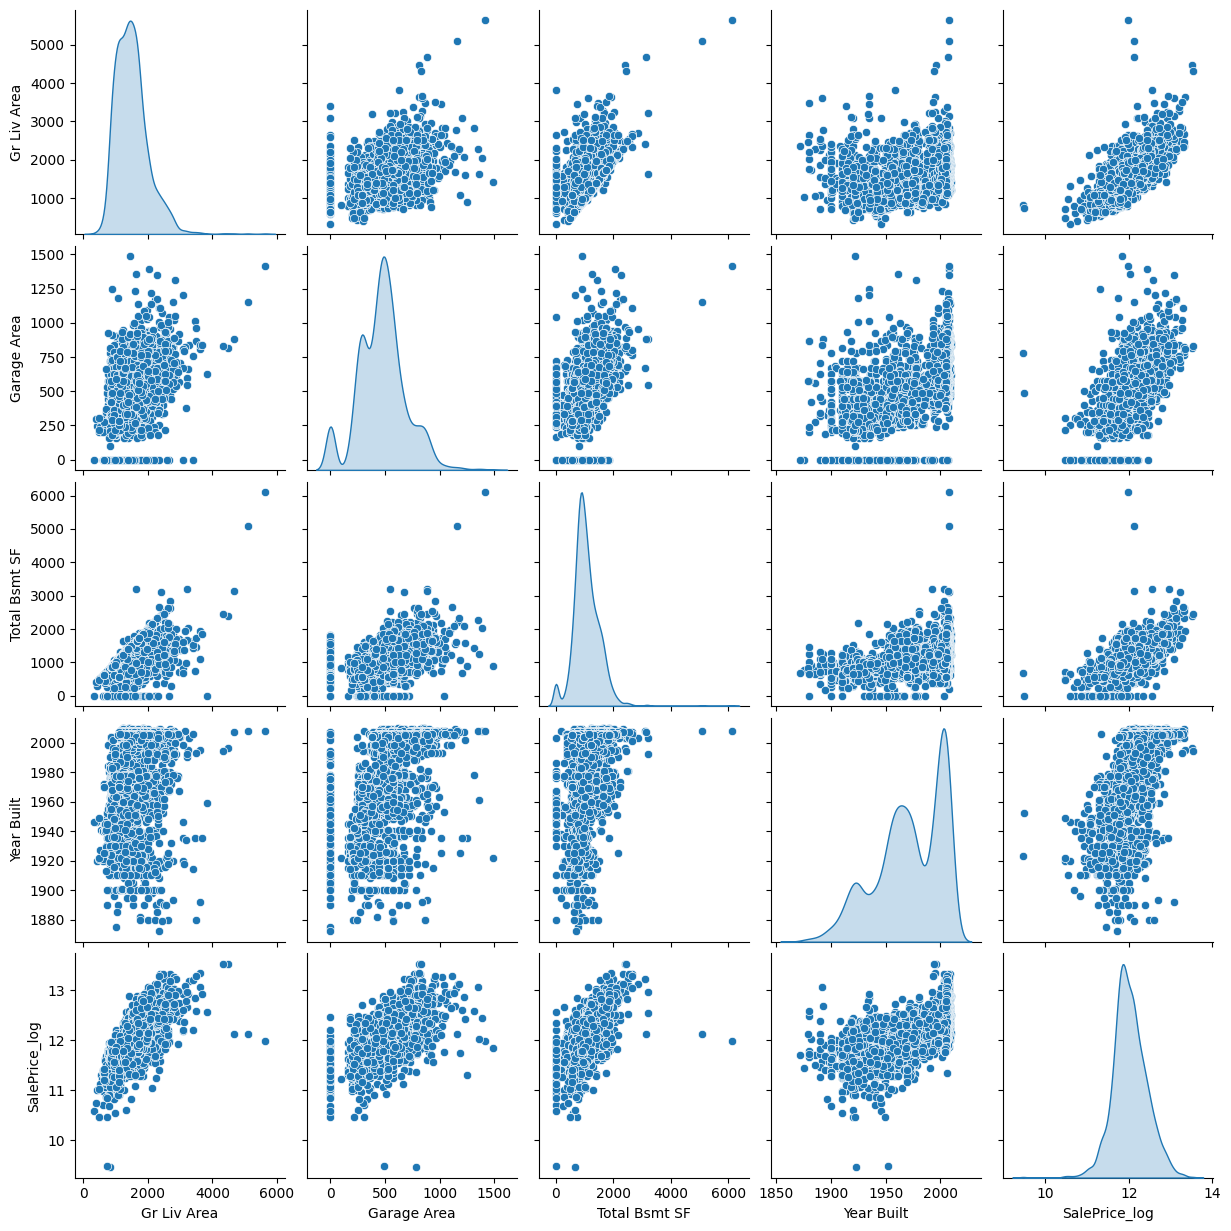

In [ ]:
key_numeric = ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', 'Year Built']
key_numeric = [c for c in key_numeric if c in df.columns]

sns.pairplot(df[key_numeric + ['SalePrice_log']], diag_kind='kde')
plt.show()

### 4.3 Categorical Feature Impact (Boxplots)

Examine how some categorical variables relate to `SalePrice_log`.

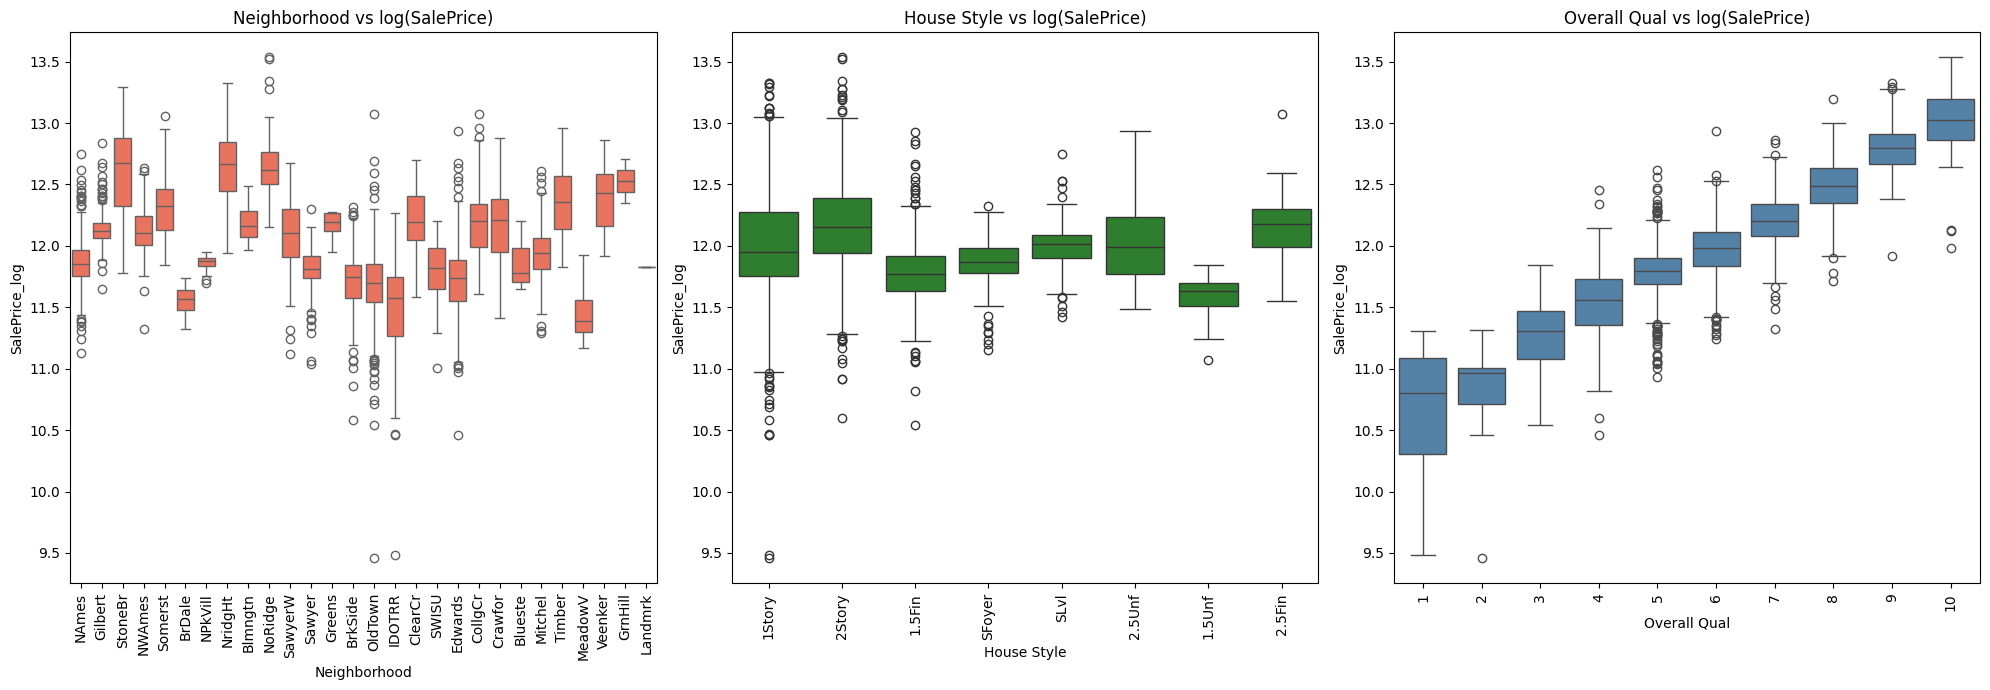

In [ ]:
cat_to_plot = ['Neighborhood', 'House Style', 'Overall Qual']
colors = ['tomato', 'forestgreen', 'steelblue']
cat_to_plot = [c for c in cat_to_plot if c in df.columns]
fig, axes = plt.subplots(1, 3, figsize=(20,7))
for i,col in enumerate(cat_to_plot):
    sns.boxplot(data=df, x=col, y='SalePrice_log', ax=axes[i], color=colors[i])
    axes[i].tick_params(axis='x', rotation=90)
    axes[i].set_title(f'{col} vs log(SalePrice)')
plt.tight_layout()

### 4.4 Missing Values by Feature Type

Visualize which columns have the most missing data.

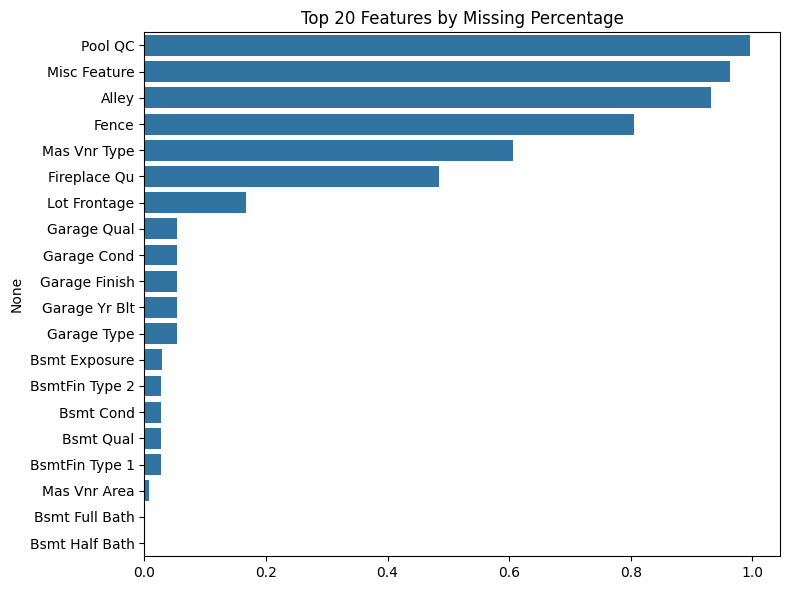

In [ ]:
missing_pct = df.isna().mean().sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=missing_pct.head(20).values, y=missing_pct.head(20).index)
plt.title('Top 20 Features by Missing Percentage')
plt.tight_layout()
plt.show()

## 5. Preprocessing Plan

We will:

- Separate the target `SalePrice_log` from features.
- Use **different encoders for different categorical types**:
  - **OrdinalEncoder** for ordered quality/condition features (e.g., `ExterQual`, `KitchenQual`, `BsmtQual`).
  - **OneHotEncoder** for nominal (unordered) categorical variables (e.g., `Neighborhood`, `HouseStyle`).
- Scale numeric features with **StandardScaler**.
- Use `ColumnTransformer` and `Pipeline` from scikit-learn.

We'll also perform simple but sensible imputations for missing values.

In [ ]:
from sklearn.model_selection import train_test_split

target = 'SalePrice_log'
X = df.drop(columns=['SalePrice', 'SalePrice_log'])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape

((2344, 81), (586, 81))

### 5.1 Define Ordinal and One-Hot Categorical Sets

We explicitly choose some ordinal quality/condition columns and treat all other categoricals as nominal (One-Hot encoded).

In [79]:
print(df.select_dtypes(include=['O']).columns)

Index(['MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour',
       'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', 'Kitchen Qual', 'Functional',
       'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual',
       'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence', 'Misc Feature',
       'Sale Type', 'Sale Condition'],
      dtype='object')


In [80]:

ordinal_quality_cols = [
    col for col in ['Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond',
                    'Heating QC', 'Kitchen Qual', 'Fireplace Qu', 'Garage Qual',
                    'Garage Cond', 'Pool QC'] if col in X_train.columns
]

# All other categoricals -> nominal
categorical_cols_all = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
nominal_categorical_cols = [c for c in categorical_cols_all if c not in ordinal_quality_cols]

len(ordinal_quality_cols), len(nominal_categorical_cols), ordinal_quality_cols[:10], nominal_categorical_cols[:10]

(10,
 33,
 ['Exter Qual',
  'Exter Cond',
  'Bsmt Qual',
  'Bsmt Cond',
  'Heating QC',
  'Kitchen Qual',
  'Fireplace Qu',
  'Garage Qual',
  'Garage Cond',
  'Pool QC'],
 ['MS Zoning',
  'Street',
  'Alley',
  'Lot Shape',
  'Land Contour',
  'Utilities',
  'Lot Config',
  'Land Slope',
  'Neighborhood',
  'Condition 1'])

### 5.2 Build ColumnTransformer with Encoders and Scaler

- Numeric: `SimpleImputer` (median) + `StandardScaler`.
- Ordinal quality: `SimpleImputer` (most_frequent) + `OrdinalEncoder` with ordered categories.
- Nominal categoricals: `SimpleImputer` (most_frequent) + `OneHotEncoder`.

In [81]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Numeric columns (recompute from X_train to avoid target leakage)
numeric_cols_train = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Define ordered categories for quality (worst -> best)
quality_order = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
ordinal_categories = [quality_order for _ in ordinal_quality_cols]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=ordinal_categories))
])

nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols_train),
        ('ord', ordinal_transformer, ordinal_quality_cols),
        ('nom', nominal_transformer, nominal_categorical_cols)
    ]
)

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Order', 'PID', 'MS SubClass', 'Lot Frontage',
                                  'Lot Area', 'Overall Qual', 'Overall Cond',
                                  'Year Built', 'Year Remod/Add',
                                  'Mas Vnr Area', 'BsmtFin SF 1',
                                  'BsmtFin SF 2', 'Bsmt Unf SF',
                                  'Total Bsmt SF', '1st Flr SF', '2nd Flr SF',
                                  'Low Qual Fin SF', 'Gr Liv Area...
                                 ['MS Zoning', 'Street', 'Alley', 'Lot Shape',
                                  'Land Contour', 'Utilities', 'Lot Config',
                                  'Land Slope', 'Neighborhood', 'Condition 1',
                                  'Condition 2', 'Bldg Type', 'House Style',
                                  'Roof Style', 'Roof Matl', 'Exterior 1st',
                                  'Exterior 2nd', 'Mas Vnr Type', 'Foundation',
                                  'Bsmt Exposure', 'BsmtFin Type 1',
                                  'BsmtFin Type 2', 'Heating', 'Central Air',
                                  'Electrical', 'Functional', 'Garage Type',
                                  'Garage Finish', 'Paved Drive', 'Fence', ...])])

## 6. Models and Evaluation

We'll train a couple of tree-based regressors:

- Random Forest Regressor
- Gradient Boosting Regressor
- Optional: XGBoost Regressor (if available)

We'll evaluate using R², RMSE (root mean squared error) on the **original SalePrice scale** by exponentiating the predictions.

In [82]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_pipe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', rf_base)
])

# Hyperparameter space
param_distributions = {
    'model__n_estimators': randint(200, 600),
    'model__max_depth': randint(3, 20),
    'model__min_samples_split': randint(2, 10),
    'model__min_samples_leaf': randint(1, 5),
    'model__max_features': ['auto', 'sqrt', 0.3, 0.5, 0.7]
}

random_search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_distributions,
    n_iter=25,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=3,
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train)

random_search.best_params_, random_search.best_score_

Fitting 3 folds for each of 25 candidates, totalling 75 fits


({'model__max_depth': 17,
  'model__max_features': 0.3,
  'model__min_samples_leaf': 2,
  'model__min_samples_split': 2,
  'model__n_estimators': 249},
 np.float64(-0.13852024741629396))

In [83]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model(model, X_train, y_train, X_test, y_test, label='Model'):
    """Fit model and print metrics on log and original scales."""
    model.fit(X_train, y_train)
    y_pred_log = model.predict(X_test)

    # Metrics on log scale
    rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
    r2_log = r2_score(y_test, y_pred_log)

    # Convert back to original SalePrice
    y_test_orig = np.expm1(y_test)
    y_pred_orig = np.expm1(y_pred_log)
    rmse_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    r2_orig = r2_score(y_test_orig, y_pred_orig)

    print(f'=== {label} ===')
    print(f'Log-scale RMSE: {rmse_log:.4f}, R2: {r2_log:.4f}')
    print(f'Original-scale RMSE: {rmse_orig:,.2f}, R2: {r2_orig:.4f}')

    return model, {
        'rmse_log': rmse_log,
        'r2_log': r2_log,
        'rmse_orig': rmse_orig,
        'r2_orig': r2_orig
    }

In [84]:
best_rf_pipe = random_search.best_estimator_
best_rf_pipe, best_rf_metrics = evaluate_model(
    best_rf_pipe,
    X_train,
    y_train,
    X_test,
    y_test,
    label='Tuned Random Forest'
)

=== Tuned Random Forest ===
Log-scale RMSE: 0.1188, R2: 0.9237
Original-scale RMSE: 26,827.47, R2: 0.9102


In [85]:
!pip install -q catboost

In [86]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

models = {}
metrics = {}

lgbm_reg = LGBMRegressor(
    n_estimators=600,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgbm_pipe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', lgbm_reg)
])

lgbm_pipe, lgbm_metrics = evaluate_model(
    lgbm_pipe,
    X_train,
    y_train,
    X_test,
    y_test,
    label='LightGBM'
)

models['LightGBM'] = lgbm_pipe
metrics['LightGBM'] = lgbm_metrics

# Note: verbose=0 to keep output clean
cb_reg = CatBoostRegressor(
    depth=6,
    learning_rate=0.05,
    loss_function='RMSE',
    n_estimators=800,
    random_seed=42,
    verbose=0
)

cb_pipe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', cb_reg)
])

cb_pipe, cb_metrics = evaluate_model(
    cb_pipe,
    X_train,
    y_train,
    X_test,
    y_test,
    label='CatBoost'
)

models['CatBoost'] = cb_pipe
metrics['CatBoost'] = cb_metrics

# Gradient Boosting Pipeline
gb_reg = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gb_pipe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', gb_reg)
])

gb_pipe, gb_metrics = evaluate_model(gb_pipe, X_train, y_train, X_test, y_test, label='Gradient Boosting')


models['GBBoost'] = gb_pipe
metrics['GBBoost'] = gb_metrics



xgb_reg = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42,
    tree_method='hist',
)

xgb_pipe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', xgb_reg)
])

xgb_pipe, xgb_metrics = evaluate_model(xgb_pipe, X_train, y_train, X_test, y_test, label='XGBoost')

models['XGBoost'] = xgb_pipe
metrics['XGBoost'] = xgb_metrics

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4281
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 187
[LightGBM] [Info] Start training from score 12.011814
=== LightGBM ===
Log-scale RMSE: 0.1107, R2: 0.9338
Original-scale RMSE: 23,132.61, R2: 0.9333
=== CatBoost ===
Log-scale RMSE: 0.0980, R2: 0.9481
Original-scale RMSE: 22,217.30, R2: 0.9384
=== Gradient Boosting ===
Log-scale RMSE: 0.1099, R2: 0.9347
Original-scale RMSE: 25,790.68, R2: 0.9170
=== XGBoost ===
Log-scale RMSE: 0.1018, R2: 0.9440
Original-scale RMSE: 23,274.00, R2: 0.9324


## 7. Model Comparison

Compare R² and RMSE among models.

In [87]:
results = []
results.append({'model': 'Random Forest', **best_rf_metrics})
results.append({'model': 'Gradient Boosting', **gb_metrics})
results.append({'model': 'XGBoost', **xgb_metrics})
results.append({'model': 'LightGBM', **lgbm_metrics})
results.append({'model': 'CatBoost', **cb_metrics})

results_df = pd.DataFrame(results)
results_df

,model,rmse_log,r2_log,rmse_orig,r2_orig
0,Random Forest,0.118823,0.923693,26827.468692,0.910233
1,Gradient Boosting,0.109894,0.934731,25790.680571,0.917037
2,XGBoost,0.101769,0.944025,23274.001607,0.932438
3,LightGBM,0.110653,0.933826,23132.610940,0.933257
4,CatBoost,0.098010,0.948084,22217.297568,0.938434


We'll pick one model for explainability analysis. Let's select the best based on original-scale RMSE (lower is better).

In [88]:
best_row = results_df.sort_values('rmse_orig').iloc[0]
best_model_name = best_row['model']
best_model_name

'CatBoost'

In [89]:
match best_model_name:
  case 'Random Forest':
    best_pipe = best_rf_pipe
  case 'Gradient Boosting':
    best_pipe = gb_pipe
  case 'XGBoost':
    best_pipe = xgb_pipe
  case 'LightGBM':
    best_pipe = lgbm_pipe
  case _:
    best_pipe = cb_pipe


## 8. Explainability: Permutation Importance

Permutation importance measures how much each feature contributes to the model's performance by randomly shuffling feature values and observing the drop in performance.

We'll:

- Get the names of the transformed features from the `ColumnTransformer`.
- Use `sklearn.inspection.permutation_importance`.
- Plot the top features.

In [90]:
from sklearn.inspection import permutation_importance

preprocess_step = best_pipe.named_steps['preprocess']
model_step = best_pipe.named_steps['model']
display(preprocess_step)
# Helper to get feature names after ColumnTransformer
def get_feature_names(column_transformer):
    output_features = []
    for name, transformer, cols in column_transformer.transformers_:
        if name == 'remainder':
            continue
        # Pipeline case
        if hasattr(transformer, 'named_steps'):
            last_step = list(transformer.named_steps.values())[-1]
        else:
            last_step = transformer

        if hasattr(last_step, 'get_feature_names_out'):
            names = last_step.get_feature_names_out(cols)
        else:
            names = cols
        output_features.extend(names)
    return output_features

feature_names = get_feature_names(preprocess_step)
len(feature_names)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Order', 'PID', 'MS SubClass', 'Lot Frontage',
                                  'Lot Area', 'Overall Qual', 'Overall Cond',
                                  'Year Built', 'Year Remod/Add',
                                  'Mas Vnr Area', 'BsmtFin SF 1',
                                  'BsmtFin SF 2', 'Bsmt Unf SF',
                                  'Total Bsmt SF', '1st Flr SF', '2nd Flr SF',
                                  'Low Qual Fin SF', 'Gr Liv Area...
                                 ['MS Zoning', 'Street', 'Alley', 'Lot Shape',
                                  'Land Contour', 'Utilities', 'Lot Config',
                                  'Land Slope', 'Neighborhood', 'Condition 1',
                                  'Condition 2', 'Bldg Type', 'House Style',
                                  'Roof Style', 'Roof Matl', 'Exterior 1st',
                                  'Exterior 2nd', 'Mas Vnr Type', 'Foundation',
                                  'Bsmt Exposure', 'BsmtFin Type 1',
                                  'BsmtFin Type 2', 'Heating', 'Central Air',
                                  'Electrical', 'Functional', 'Garage Type',
                                  'Garage Finish', 'Paved Drive', 'Fence', ...])])

265

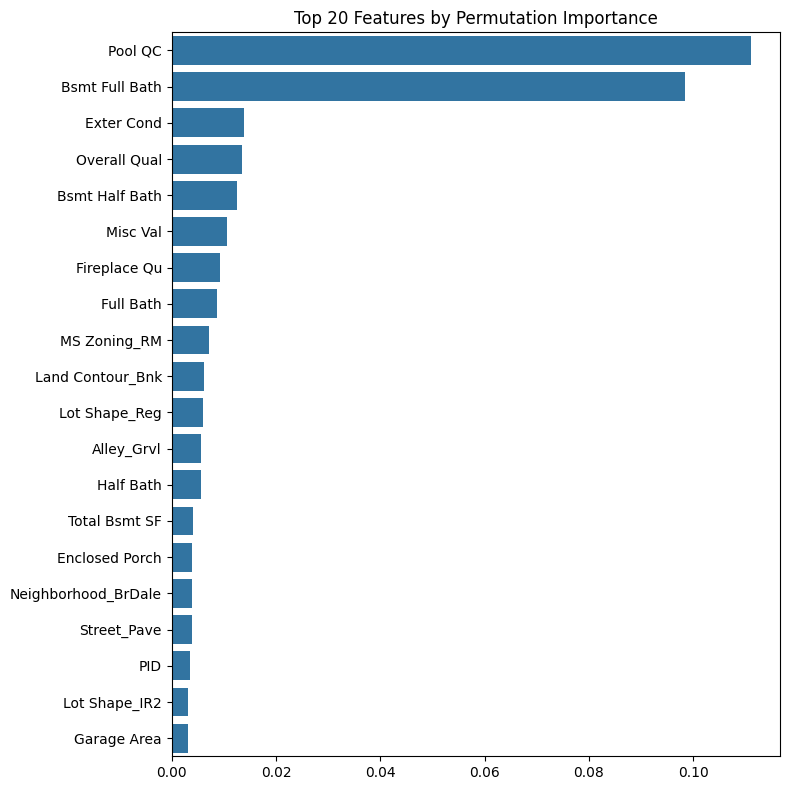

In [91]:
# Compute permutation importance on test set
perm_result = permutation_importance(
    best_pipe,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

importances = perm_result.importances_mean
indices = np.argsort(importances)[::-1]

top_n = 20
top_indices = indices[:top_n]
plt.figure(figsize=(8, 8))
sns.barplot(
    x=importances[top_indices],
    y=np.array(feature_names)[top_indices]
)
plt.title(f'Top {top_n} Features by Permutation Importance')
plt.tight_layout()
plt.show()

## 9. Explainability: SHAP Values

We'll use SHAP to:

- Explain global feature importance (summary plot).
- Inspect individual predictions (force/decision plots, depending on model type).

**Note:** For tree-based models, we can use `shap.TreeExplainer`. SHAP can be slow on large datasets, so we will sample a subset of the data for plotting.

In [92]:
import shap

shap.initjs()

# Create a simpler object: model on top of preprocessed features
X_train_trans = preprocess_step.fit_transform(X_train)

# Refit a copy of the underlying model directly on transformed data
model_class = type(model_step)
model_for_shap = model_class(**model_step.get_params())
model_for_shap.fit(X_train_trans, y_train)

# Sample for SHAP to keep it fast
sample_size = min(1000, X_train_trans.shape[0])
idx = np.random.choice(X_train_trans.shape[0], sample_size, replace=False)
X_shap = X_train_trans[idx]

# Use TreeExplainer for tree-based models
explainer = shap.TreeExplainer(model_for_shap)
shap_values = explainer.shap_values(X_shap)
len(shap_values), X_shap.shape

(1000, (1000, 265))

### 9.1 Global SHAP Summary Plot

This shows how each feature impacts the model output across many samples.

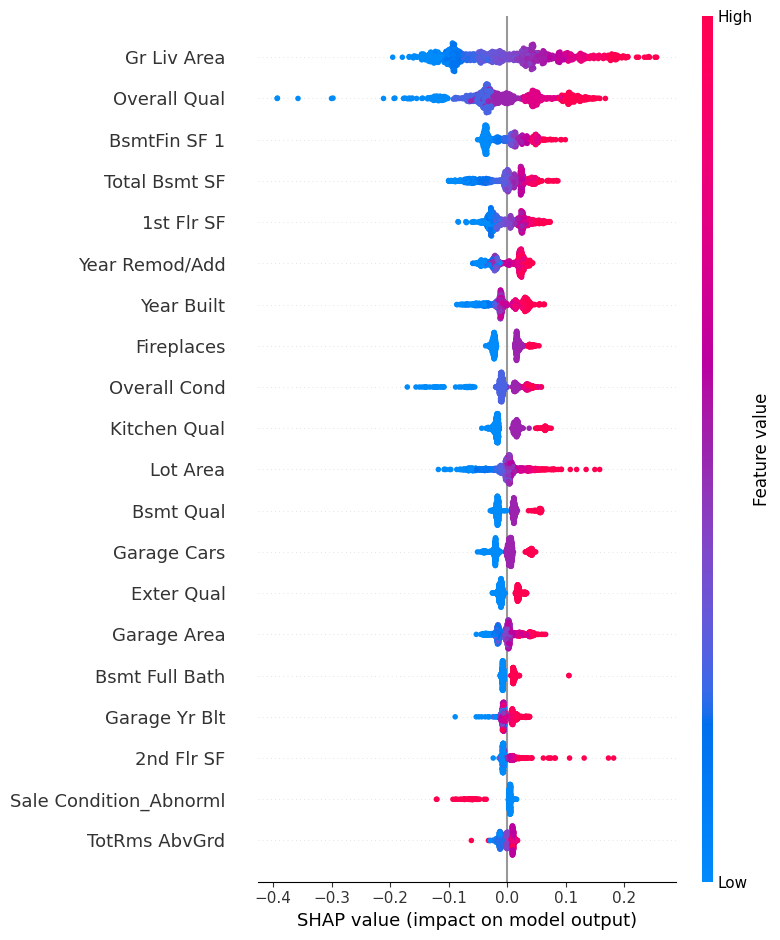

In [93]:
shap.summary_plot(shap_values, X_shap, feature_names=feature_names, show=False)
plt.tight_layout()
plt.show()

### 9.2 SHAP Bar Plot (Mean Absolute SHAP Values)

Another global view focusing on average magnitude of feature impact.

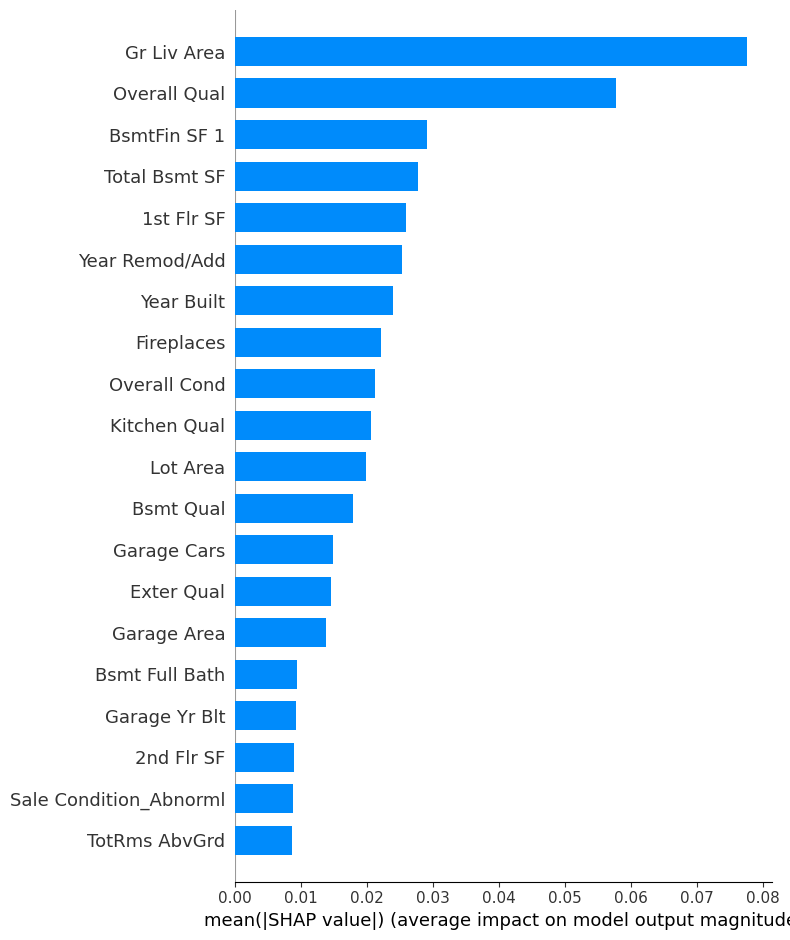

In [94]:
shap.summary_plot(shap_values, X_shap, feature_names=feature_names, plot_type='bar', show=False)
plt.tight_layout()
plt.show()

### 9.3 Local Explanations for Individual Predictions

Inspect the SHAP values for a single observation to understand why the model predicts a particular price.

In [96]:
shap.initjs()
# Pick one example from the test set
x_example = X_test.iloc[[0]]

# Transform it and compute SHAP values
x_example_trans = preprocess_step.transform(x_example)
shap_values_example = explainer.shap_values(x_example_trans)

print('Predicted log(SalePrice):', model_for_shap.predict(x_example_trans)[0])
print('Predicted SalePrice:', np.expm1(model_for_shap.predict(x_example_trans))[0])

shap.force_plot(
    explainer.expected_value,
    shap_values_example,
    x_example_trans,
    feature_names=feature_names
)

Predicted log(SalePrice): 12.008073970927121
Predicted SalePrice: 164073.1880908502


In [98]:
import joblib

model_filename = 'best_ames_model_fe.joblib'
joblib.dump(best_pipe, model_filename)
model_filename

'best_ames_model_fe.joblib'